In [76]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
from iris.time import PartialDateTime
from iris.util import mask_cube_from_shapefile
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely import MultiPolygon, Polygon

import os
import torch
import pandas as pd
import sklearn
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable 
from torch.utils.data import DataLoader, TensorDataset

import sklearn.preprocessing 


In [77]:
filenames = ['C:/Users/Tilt/Downloads/Project/Data/data_2010.nc','C:/Users/Tilt/Downloads/Project/Data/data_2011.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2012.nc','C:/Users/Tilt/Downloads/Project/Data/data_2013.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2014.nc','C:/Users/Tilt/Downloads/Project/Data/data_2015.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2016.nc','C:/Users/Tilt/Downloads/Project/Data/data_2017.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2018.nc','C:/Users/Tilt/Downloads/Project/Data/data_2019.nc']
cubes = iris.load(filenames)
cubes = cubes.concatenate()
#print(cubes)

In [78]:
ConstraintNames = [
    'burned_area',
    'population_density',
    '10 metre wind speed',
    '2 metre temperature',
    'Convective available potential energy',
    'Leaf area index, high vegetation',
    'Leaf area index, low vegetation',
    'Total precipitation',
    'Volumetric soil water layer 1',
    'observed_fraction_mask',
    'standard error of the estimation of burned area'
]

cubesList = { name: cubes.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 120; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 120; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 120; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 120; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 120; latitude: 720; longitude: 1440)>, 'Volu

In [79]:
CountryName = "Portugal"

country_shp_reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="110m", category="cultural", name="admin_0_countries"
    )
)
Country_shp = [
    country.geometry
    for country in country_shp_reader.records()
    if CountryName in country.attributes["NAME_LONG"]
][0]
ObsMaskCube = mask_cube_from_shapefile(cubesList["observed_fraction_mask"], Country_shp)
ObsMaskCube = iris.analysis.maths.log(ObsMaskCube)
ObsMaskCube = iris.analysis.maths.exp(ObsMaskCube)

b=0
a = ObsMaskCube.data
print("Verification - Count should Equal Sum")
print("Count =",ma.count(a))
print("Sum =",np.sum(a))
if(np.round(np.sum(a)) == ma.count(a)):
    b=b+1
print("Verification Mean should = 1")
print("Mean = ",np.mean(a))
if(np.round(np.mean(a)) == 1):
    b=b+1
print("We have",ma.count(a),"Datapoints Per Month")
if(b==2):
    print("All Verified - Continue")
else:
    print("Somethings gone wrong.")

BurnedCube = iris.analysis.maths.multiply(cubesList["burned_area"], ObsMaskCube)
PopnCube = iris.analysis.maths.multiply(cubesList["population_density"], ObsMaskCube)
WindCube = iris.analysis.maths.multiply(cubesList["10 metre wind speed"], ObsMaskCube)
TempCube = iris.analysis.maths.multiply(cubesList["2 metre temperature"], ObsMaskCube)
CAPECube = iris.analysis.maths.multiply(cubesList["Convective available potential energy"], ObsMaskCube)
HVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube = iris.analysis.maths.multiply(cubesList["Total precipitation"], ObsMaskCube)
SoilCube = iris.analysis.maths.multiply(cubesList["Volumetric soil water layer 1"], ObsMaskCube)

c:\Users\Tilt\miniconda3\Lib\site-packages\iris\_shapefiles.py:147: IrisDefaultingWarning: Cube has no coord_system; using default GeogCS lat/lon
  warnings.warn(


Verification - Count should Equal Sum
Count = 173
Sum = 173.0
Verification Mean should = 1
Mean =  1.0
We have 173 Datapoints Per Month
All Verified - Continue


(120, 720, 1440)
[0.0 0.0 0.0 ... 0.0 0.0 0.0]
20760
173


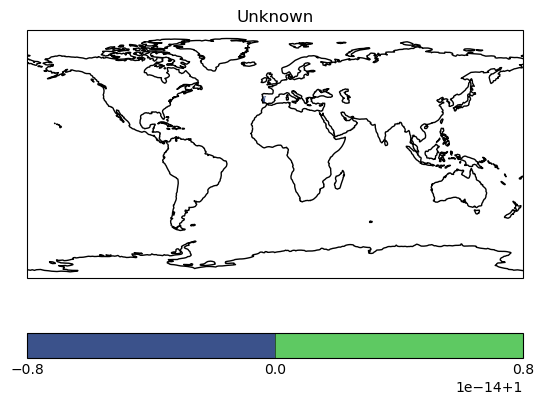

In [80]:
a = BurnedCube.data
print(np.shape(a))
aNoMask = a[~a.mask]
print(aNoMask)
print(len(aNoMask))

aMonth = BurnedCube[0].data
aNoMaskMonth = aMonth[~aMonth.mask]
print(len(aNoMaskMonth))
# 173 Datapoints Per for Portugal
Timesteps = round(len(aNoMask)/len(aNoMaskMonth))
Samples = len(aNoMaskMonth)

qplt.contourf(ObsMaskCube, 25)
plt.gca().coastlines()
plt.show()

In [81]:
def DeCube(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(Timesteps, Samples)
    return InCube

In [82]:
#Verifying this doesnt break it
#a = BurnedCube.data
#a = a[~a.mask]
#print(len(a))

Burned = DeCube(BurnedCube)

Popn = DeCube(PopnCube)
Wind = DeCube(WindCube)
Temp = DeCube(TempCube)
CAPE = DeCube(CAPECube)
HVeg = DeCube(HVegCube)
LVeg = DeCube(LVegCube)
Precip = DeCube(PrecipCube)
Soil = DeCube(SoilCube)

# Popn = np.log(Popn)

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Popn)
Popn = scaler.transform(Popn) 
scaler.fit(Wind)
Wind = scaler.transform(Wind) 
scaler.fit(Temp)
Temp = scaler.transform(Temp) 
scaler.fit(CAPE)
CAPE = scaler.transform(CAPE) 
scaler.fit(HVeg)
HVeg = scaler.transform(HVeg) 
scaler.fit(LVeg)
LVeg = scaler.transform(LVeg) 
scaler.fit(Precip)
Precip = scaler.transform(Precip) 
scaler.fit(Soil)
Soil = scaler.transform(Soil) 

print("Num WildFires = ", len(Burned[Burned>0]))

X_full = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil,Burned))
print(X_full.shape)
X_full = X_full.reshape(-1, X_full.shape[-1])
print(X_full.shape)
X_fullNonZero = X_full[X_full[:,-1]>0]
print(X_fullNonZero.shape)

y_fullNonZero = X_fullNonZero[:,-1]
X_fullNonZero = X_fullNonZero[:,0:8]

NumNonZero = X_fullNonZero.shape[0]

y_fullNonZero = (y_fullNonZero)
y_fullNonZero = y_fullNonZero.reshape(NumNonZero,1)

#print(X_fullNonZero)
#print(y_fullNonZero)

np.random.seed(42)
sample = np.random.choice([True, True, True, True, False], (NumNonZero, 1))
print(sample.shape)
X_fullNonZeroTrain = X_fullNonZero * sample
X_fullNonZeroTest = X_fullNonZero * (1-sample)
#print(X_fullNonZeroTrain)

y_train = y_fullNonZero * sample
y_test = y_fullNonZero * (1-sample)
X_fullNonZeroTrain = X_fullNonZeroTrain[~np.all(X_fullNonZeroTrain == 0, axis=1)]
X_fullNonZeroTest = X_fullNonZeroTest[~np.all(X_fullNonZeroTest == 0, axis=1)]
y_train = y_train[~np.all(y_train == 0, axis=1)]
y_test = y_test[~np.all(y_test == 0, axis=1)]

X_train = X_fullNonZeroTrain
X_test = X_fullNonZeroTest

#y_train = np.log(y_train)
#y_test = np.log(y_test)

#scalerY = sklearn.preprocessing.minmax_scale
#scalerY.fit(y_train)
#y_train = scalerY.transform(y_train) 
#y_test = scalerY.transform(y_test) 

print("Training Shape",X_train.shape,y_train.shape)
print("Testing Shape",X_test.shape,y_test.shape)

Num WildFires =  1500
(120, 173, 9)
(20760, 9)
(1500, 9)
(1500, 1)
Training Shape (1189, 8) (1189, 1)
Testing Shape (311, 8) (311, 1)


In [83]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=9,weights='distance',p=2)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)
print(y_pred.shape)
#print(y_test.ravel().shape)
#Delta = y_test.ravel() - y_pred
#print(Delta.mean())

(311,)


In [84]:
y_predUnsc = y_pred#scalerY.inverse_transform(y_pred.reshape(-1,1))
y_testUnsc = y_test#scalerY.inverse_transform(y_test)
DeltaUnsc = y_predUnsc - y_testUnsc
#print(DeltaUnsc.mean())
y_predReal = y_predUnsc#np.exp(y_predUnsc)
y_testReal = y_testUnsc#np.exp(y_testUnsc)

DeltaReal = y_predReal - y_testReal
DeltaReal = abs(DeltaReal)
Perc = (np.abs(DeltaReal)/y_testReal)
#print(Perc.mean())
#print(y_predReal.mean())
#print(y_testReal.mean())
#print(DeltaReal.mean())

In [85]:
SECube = iris.analysis.maths.multiply(cubesList['standard error of the estimation of burned area'], ObsMaskCube)
SE = DeCube(SECube)
SE = SE.reshape(-1)
#print(SE.shape)
SE = SE[X_full[:,-1]>0]
SE = SE.reshape(NumNonZero,1)
SEtest = SE * (1-sample)
SEtest = SEtest[~np.all(SEtest == 0, axis=1)]
#print(SEtest.shape)
#print(DeltaReal.shape)
CompColV = np.hstack((SEtest,DeltaReal))
IsVAccurateCol = np.zeros((y_pred.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsVAccurateCol.shape[0]):
    if CompColV[i,1] > CompColV[i,0]:
        IsVAccurateCol[i,0] = 0
    else:
        IsVAccurateCol[i,0] = 1
print("Percentage of Predictions within 1*SE of Burned Area =",IsVAccurateCol.mean())
CompCol = np.hstack((2*SEtest,DeltaReal))
IsAccurateCol = np.zeros((y_pred.shape[0],1))
#print(IsAccurateCol.shape[0])
for i in range(IsAccurateCol.shape[0]):
    if CompCol[i,1] > CompCol[i,0]:
        IsAccurateCol[i,0] = 0
    else:
        IsAccurateCol[i,0] = 1
print("Percentage of Predictions within 2*SE of Burned Area =",IsAccurateCol.mean())
CompColNR = np.hstack((3*SEtest,DeltaReal))
IsNRAccurateCol = np.zeros((y_pred.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsNRAccurateCol.shape[0]):
    if CompColNR[i,1] > CompColNR[i,0]:
        IsNRAccurateCol[i,0] = 0
    else:
        IsNRAccurateCol[i,0] = 1
print("Percentage of Predictions within 3*SE of Burned Area =",IsNRAccurateCol.mean())
# Plot Histo of Pred vs Real

Percentage of Predictions within 1*SE of Burned Area = 0.3022508038585209
Percentage of Predictions within 2*SE of Burned Area = 0.45016077170418006
Percentage of Predictions within 3*SE of Burned Area = 0.5659163987138264


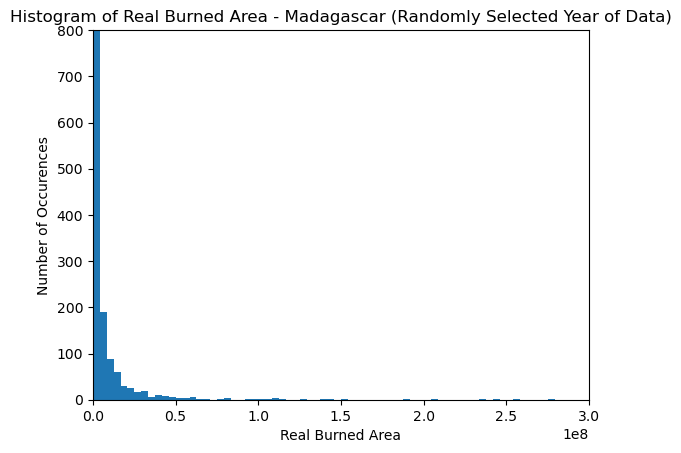

In [86]:
y_testRealYear = y_fullNonZero
np.random.shuffle(y_testRealYear) 
y_testRealYear = y_testRealYear[:2000,]
plt.hist(y_testRealYear, bins=100)
plt.axis([0, 300000000,0,800])
plt.title("Histogram of Real Burned Area - Madagascar (Randomly Selected Year of Data)")
plt.xlabel("Real Burned Area")
plt.ylabel("Number of Occurences")
plt.show()

(75,)
(311, 8)


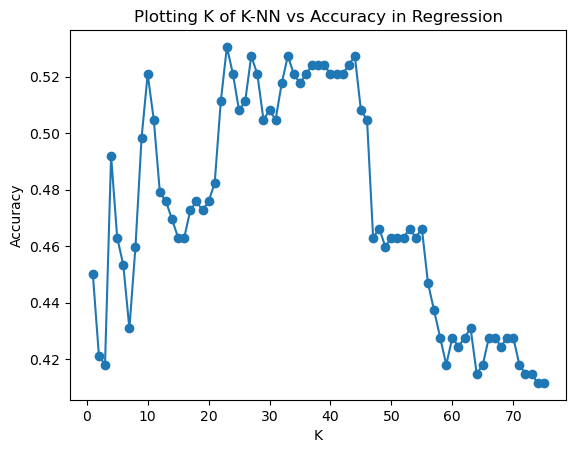

In [87]:
Q=75
accuracy = np.zeros((Q,))
xlab = np.zeros((Q,))
print(accuracy.shape)
X_testsmall = X_test[:800,]
y_testsmall = y_test[:800,]
print(X_testsmall.shape)
SEtestsmall = SEtest[:800,]
for i in range(Q):
    regressor = KNeighborsRegressor(n_neighbors=i+1,weights='uniform',p=1)
    regressor.fit(X_train, y_train.ravel())
    y_predsmall = regressor.predict(X_testsmall)
    y_predUnsc = y_predsmall#scalerY.inverse_transform(y_pred.reshape(-1,1))
    y_testUnsc = y_testsmall#scalerY.inverse_transform(y_test)
    y_predReal = y_predUnsc#np.exp(y_predUnsc)
    y_testReal = y_testUnsc#np.exp(y_testUnsc)
    DeltaReal = y_predReal - y_testReal
    DeltaReal = abs(DeltaReal)
    CompCol = np.hstack((2*SEtestsmall,DeltaReal))
    IsAccurateCol = np.zeros((y_predsmall.shape[0],1))
    for j in range(IsAccurateCol.shape[0]):
        if CompCol[j,1] > CompCol[j,0]:
            IsAccurateCol[j,0] = 0
        else:
            IsAccurateCol[j,0] = 1
    accuracy[i,] = IsAccurateCol.mean()
    xlab[i,] = i+1

plt.plot(xlab,accuracy, marker = 'o')
plt.title("Plotting K of K-NN vs Accuracy in Regression")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

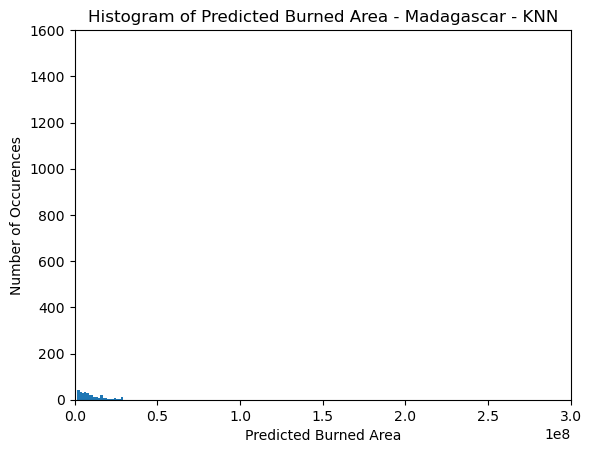

In [88]:
plt.hist(y_predReal, bins=20)
plt.axis([0, 300000000,0,1600])
plt.title("Histogram of Predicted Burned Area - Madagascar - KNN")
plt.xlabel("Predicted Burned Area")
plt.ylabel("Number of Occurences")
plt.show()

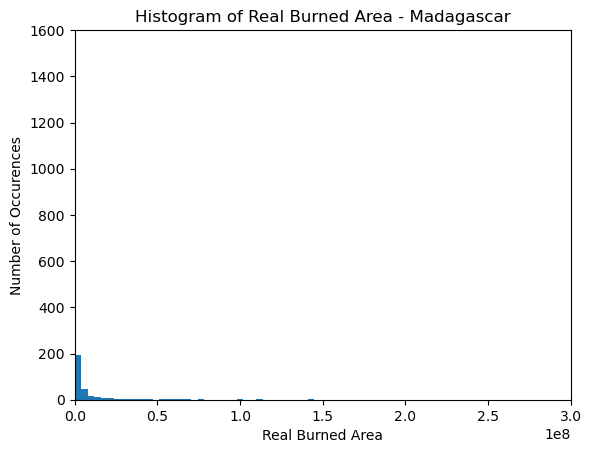

In [89]:
plt.hist(y_testReal, bins=100)
plt.axis([0, 300000000,0,1600])
plt.title("Histogram of Real Burned Area - Madagascar")
plt.xlabel("Real Burned Area")
plt.ylabel("Number of Occurences")
plt.show()

Delta = ~1/3

Same as Linear, more reproducible tho

In [90]:
#2020
filename2020 = 'C:/Users/Tilt/Downloads/Project/Data/data_2020.nc'
cube2020 = iris.load(filename2020)
cubesList2020 = { name: cube2020.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList2020)
BurnedCube2020 = iris.analysis.maths.multiply(cubesList2020["burned_area"], ObsMaskCube)
PopnCube2020 = iris.analysis.maths.multiply(cubesList2020["population_density"], ObsMaskCube)
WindCube2020 = iris.analysis.maths.multiply(cubesList2020["10 metre wind speed"], ObsMaskCube)
TempCube2020 = iris.analysis.maths.multiply(cubesList2020["2 metre temperature"], ObsMaskCube)
CAPECube2020 = iris.analysis.maths.multiply(cubesList2020["Convective available potential energy"], ObsMaskCube)
HVegCube2020 = iris.analysis.maths.multiply(cubesList2020["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube2020 = iris.analysis.maths.multiply(cubesList2020["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube2020 = iris.analysis.maths.multiply(cubesList2020["Total precipitation"], ObsMaskCube)
SoilCube2020 = iris.analysis.maths.multiply(cubesList2020["Volumetric soil water layer 1"], ObsMaskCube)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 12; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 12; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 12; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 12; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 12; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 12; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 12; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 12; latitude: 720; longitude: 1440)>, 'Volumetric s

In [91]:
def DeCube2020(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(12,Samples)
    return InCube

In [92]:
Burned2020 = DeCube2020(BurnedCube2020)
Popn2020 = DeCube2020(PopnCube2020)
Wind2020 = DeCube2020(WindCube2020)
Temp2020 = DeCube2020(TempCube2020)
CAPE2020 = DeCube2020(CAPECube2020)
HVeg2020 = DeCube2020(HVegCube2020)
LVeg2020 = DeCube2020(LVegCube2020)
Precip2020 = DeCube2020(PrecipCube2020)
Soil2020 = DeCube2020(SoilCube2020)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Popn2020)
Popn2020 = scaler.transform(Popn2020) 
scaler.fit(Wind2020)
Wind2020 = scaler.transform(Wind2020) 
scaler.fit(Temp2020)
Temp2020 = scaler.transform(Temp2020) 
scaler.fit(CAPE2020)
CAPE2020 = scaler.transform(CAPE2020) 
scaler.fit(HVeg2020)
HVeg2020 = scaler.transform(HVeg2020) 
scaler.fit(LVeg2020)
LVeg2020 = scaler.transform(LVeg2020) 
scaler.fit(Precip2020)
Precip2020 = scaler.transform(Precip2020) 
scaler.fit(Soil2020)
Soil2020 = scaler.transform(Soil2020) 

X_full2020 = np.dstack((Popn2020,Wind2020,Temp2020,CAPE2020,HVeg2020,LVeg2020,Precip2020,Soil2020,Burned2020))
print(X_full2020.shape)
X_full2020 = X_full2020.reshape(-1, X_full2020.shape[-1])
print(X_full2020.shape)
X_fullNonZero2020 = X_full2020[X_full2020[:,8]>0]
print(X_fullNonZero2020.shape)

y_fullNonZero2020 = X_fullNonZero2020[:,-1]
X_fullNonZero2020 = X_fullNonZero2020[:,0:8]

NumNonZero2020 = X_fullNonZero2020.shape[0]

y_fullNonZero2020 = y_fullNonZero2020.reshape(NumNonZero2020,1)

X_test2020 = X_fullNonZero2020[~np.all(X_fullNonZero2020 == 0, axis=1)]
y_test2020 = y_fullNonZero2020[~np.all(y_fullNonZero2020 == 0, axis=1)]

#scalerY = MinMaxScaler()
#scalerY.fit(y_train)
#y_train = scalerY.transform(y_train) 
#y_test = scalerY.transform(y_test) 

print("Testing Shape 2020",X_test2020.shape,y_test2020.shape)
print("# Wildfires 2020 = ", X_test2020.shape[0])

(12, 173, 9)
(2076, 9)
(105, 9)
Testing Shape 2020 (105, 8) (105, 1)
# Wildfires 2020 =  105


In [93]:
regressor = KNeighborsRegressor(n_neighbors=9,weights='distance',p=2)
regressor.fit(X_train, y_train.ravel())
y_pred2020 = regressor.predict(X_test2020)

DeltaReal2020 = y_pred2020 - y_test2020
DeltaReal2020 = abs(DeltaReal2020)

In [94]:
SECube2020 = iris.analysis.maths.multiply(cubesList2020['standard error of the estimation of burned area'], ObsMaskCube)
SE2020 = DeCube2020(SECube2020)
SE2020 = SE2020.reshape(-1)
#print(SE.shape)
SE2020 = SE2020[X_full2020[:,8]>0]
SE2020 = SE2020.reshape(NumNonZero2020,1)
#print(SEtest.shape)
#print(DeltaReal.shape)
CompColV2020 = np.hstack((SE2020,DeltaReal2020))
IsVAccurateCol2020 = np.zeros((y_pred2020.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsVAccurateCol2020.shape[0]):
    if CompColV2020[i,1] > CompColV2020[i,0]:
        IsVAccurateCol2020[i,0] = 0
    else:
        IsVAccurateCol2020[i,0] = 1
print("Percentage of Predictions within 1*SE of Burned Area 2020 =",IsVAccurateCol2020.mean())
CompCol2020 = np.hstack((2*SE2020,DeltaReal2020))
IsAccurateCol2020 = np.zeros((y_pred2020.shape[0],1))
#print(IsAccurateCol.shape[0])
for i in range(IsAccurateCol2020.shape[0]):
    if CompCol2020[i,1] > CompCol2020[i,0]:
        IsAccurateCol2020[i,0] = 0
    else:
        IsAccurateCol2020[i,0] = 1
print("Percentage of Predictions within 2*SE of Burned Area 2020 =",IsAccurateCol2020.mean())
CompColNR2020 = np.hstack((3*SE2020,DeltaReal2020))
IsNRAccurateCol2020 = np.zeros((y_pred2020.shape[0],1))
#print(IsVAccurateCol.shape[0])
for i in range(IsNRAccurateCol2020.shape[0]):
    if CompColNR2020[i,1] > CompColNR2020[i,0]:
        IsNRAccurateCol2020[i,0] = 0
    else:
        IsNRAccurateCol2020[i,0] = 1
print("Percentage of Predictions within 3*SE of Burned Area =",IsNRAccurateCol2020.mean())

Percentage of Predictions within 1*SE of Burned Area 2020 = 0.38095238095238093
Percentage of Predictions within 2*SE of Burned Area 2020 = 0.5238095238095238
Percentage of Predictions within 3*SE of Burned Area = 0.580952380952381


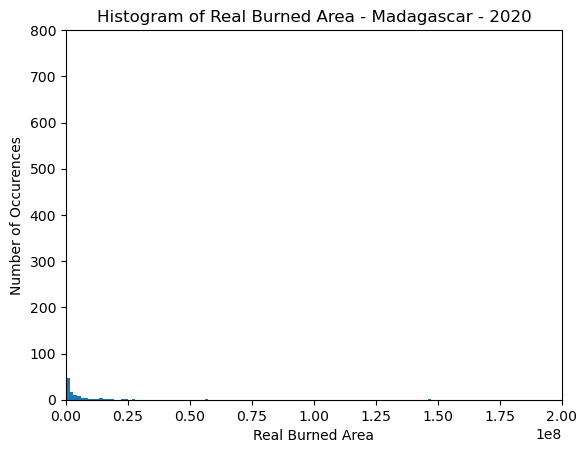

In [95]:
plt.hist(y_test2020, bins=100)
plt.axis([0, 200000000,0,800])
plt.title("Histogram of Real Burned Area - Madagascar - 2020")
plt.xlabel("Real Burned Area")
plt.ylabel("Number of Occurences")
plt.show()

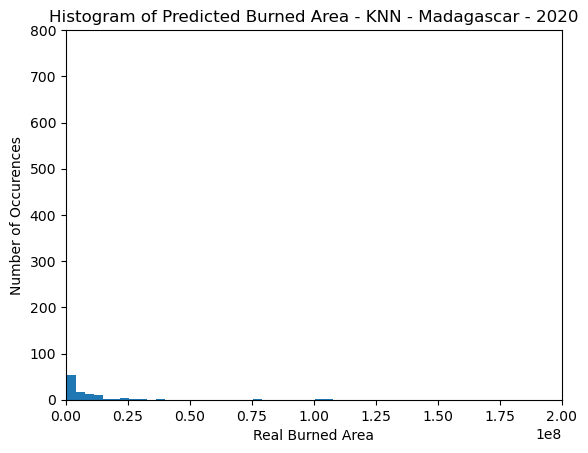

In [96]:
plt.hist(y_pred2020, bins=30)
plt.axis([0, 200000000,0,800])
plt.title("Histogram of Predicted Burned Area - KNN - Madagascar - 2020")
plt.xlabel("Real Burned Area")
plt.ylabel("Number of Occurences")
plt.show()